In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.linear_model as sklm
import sklearn.covariance as skc

import requests
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('darkgrid')

## Loading Data and Preprocessing

In [22]:
def fetch_data(country):
    """
    Return the data for `country` as a dataframe
    """
    response = requests.get(f'https://api.covid19api.com/total/dayone/country/{country}', timeout=5)
    if response.status_code == 200:
        json = response.text
        df = pd.read_json(json)
        df.set_index('Date', inplace=True)
        df.index.name = None
        return df[['Active', 'Recovered', 'Deaths', 'Confirmed']]
    else:
        raise requests.RequestException(f'Error code: {response.status_code}')

To find the name for a country, go to https://api.covid19api.com/countries, find your country, and copy the `Slug`.

In [23]:
# Covid-19 data of India
df = fetch_data('india')
df.head()

,Active,Recovered,Deaths,Confirmed
2020-01-30 00:00:00+00:00,1,0,0,1
2020-01-31 00:00:00+00:00,1,0,0,1
2020-02-01 00:00:00+00:00,1,0,0,1
2020-02-02 00:00:00+00:00,2,0,0,2
2020-02-03 00:00:00+00:00,3,0,0,3


In [24]:
cols = df.columns
print(cols)
df.tail()

Index(['Active', 'Recovered', 'Deaths', 'Confirmed'], dtype='object')


,Active,Recovered,Deaths,Confirmed
2020-07-25 00:00:00+00:00,468002,885573,32060,1385635
2020-07-26 00:00:00+00:00,485277,917568,32771,1435616
2020-07-27 00:00:00+00:00,495499,951166,33408,1480073
2020-07-28 00:00:00+00:00,509447,988029,34193,1531669
2020-07-29 00:00:00+00:00,527273,1019735,34955,1581963


## See the trend in data

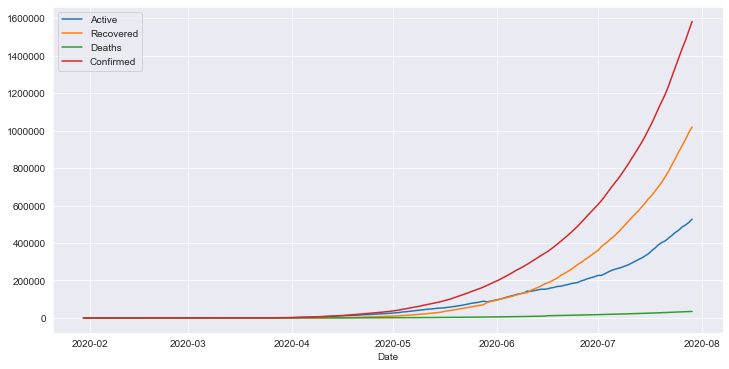

In [25]:
for c in cols:
    plt.plot(df[c], label=c)
    plt.legend()
    plt.xlabel('Date')

In [26]:
# Covid-19 data of Andorra
df_andorra = fetch_data('andorra')
df_andorra.tail()

,Active,Recovered,Deaths,Confirmed
2020-07-25 00:00:00+00:00,42,803,52,897
2020-07-26 00:00:00+00:00,42,803,52,897
2020-07-27 00:00:00+00:00,52,803,52,907
2020-07-28 00:00:00+00:00,52,803,52,907
2020-07-29 00:00:00+00:00,62,804,52,918


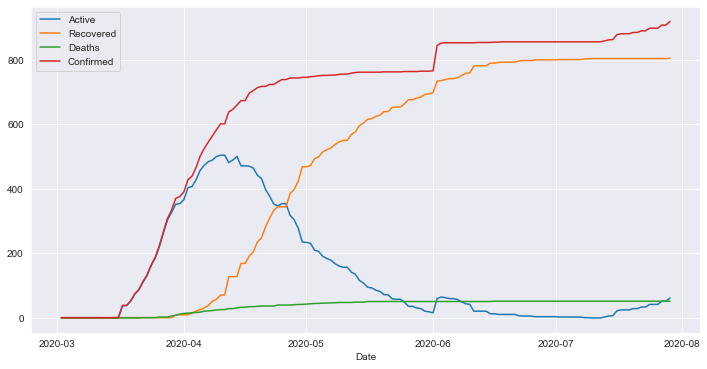

In [27]:
for c in cols:
    plt.plot(df_andorra[c], label=c)
    plt.legend()
    plt.xlabel('Date')

Comparing the graphs, it is apparent that the infection follows the above model. The equation for infection is (from https://www.researchgate.net/publication/308744463_An_Algebraic_Solution_for_the_Kermack-McKendrick_Model)

\begin{equation*}
I(\tau) = \frac{\omega}{R_0} - S(0)e^{\omega-R_0}
\end{equation*}

This shows that we can use exponential regression (linear regression thereby) to predict the number of cases for atleast a day in future.

### The other observation

Let's see how the number of recovery and active cases are related. Nothing is apparent from the graph above, instead we'll check for the differences.

Text(0.5, 1.0, 'Relation between Recovery And Active cases')

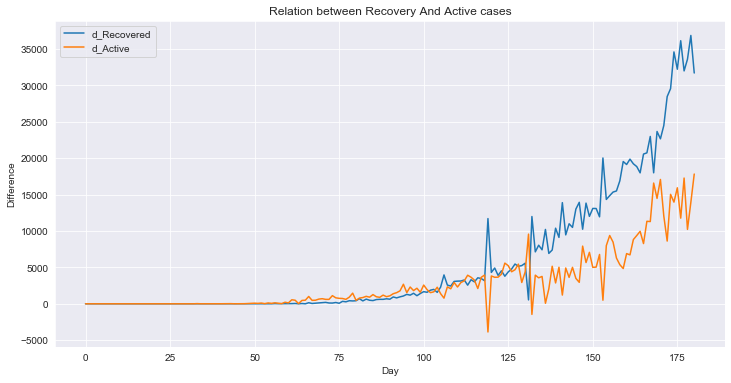

In [28]:
d_recov = np.diff(df['Recovered'])
d_activ = np.diff(df['Active'])


plt.plot(d_recov, label='d_Recovered')
plt.plot(d_activ, label='d_Active')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Difference')
plt.title('Relation between Recovery And Active cases')

Although nothing is apparent still, we can see that if one goes up, the other goes down. This is understandable since the number of active cases will decrease if more people recover. We'll check for another difference.

Text(0.5, 1.0, 'Second Difference')

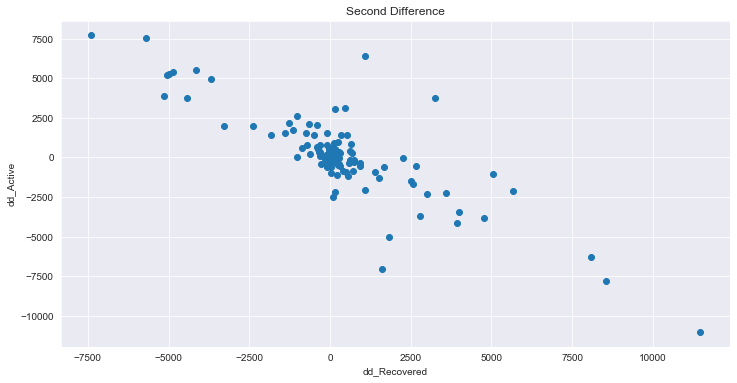

In [29]:
dd_recov = np.diff(d_recov)
dd_activ = np.diff(d_activ)


plt.scatter(dd_recov, dd_activ)
plt.xlabel('dd_Recovered')
plt.ylabel('dd_Active')
plt.title('Second Difference')

This graph shows a clear linear relation between the two, as expected. We'll use this info to get one of the values from the other. Also, if $x$ and $y$ are exponentially related, than either $e^x$ and $y$, or $x$ and $\log y$ will be linearly related. We'll use the second option since it allows to keep the numbers small.

Moreover, in the dataset, `Confirmed = Active + Recovered + Deaths`.

We've the process necessary for making predictions. As an additional step we'll use a moving window for making successive prediction since the trend in data is supposed to change (like, active cases first increases, then decreases).

Text(0, 0.5, 'log(cases)')

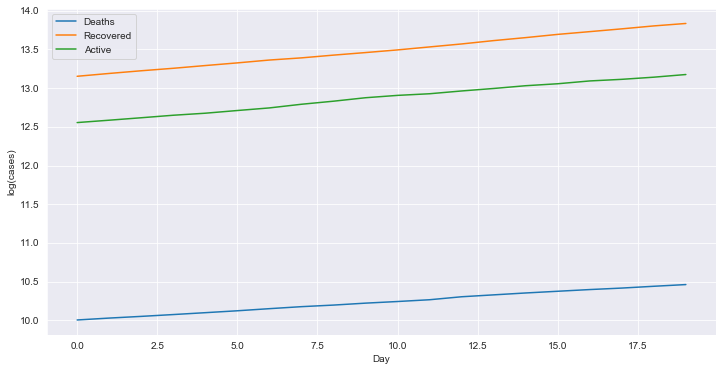

In [30]:
window_size = 20
last_df = df[-window_size:]
# last_df = df[-25:-5]


x = np.array([last_df.index.dayofyear]).T
x -= x.min()
yd, yr, ya = np.array(last_df['Deaths']), np.array(last_df['Recovered']), np.array(last_df['Active'])
lyd, lyr, lya = np.log((yd, yr, ya))  # transform coordinate


plt.plot(x.T[0], lyd, label='Deaths')
plt.plot(x.T[0], lyr, label='Recovered')
plt.plot(x.T[0], lya, label='Active')
plt.legend()
plt.xlabel('Day')
plt.ylabel('log(cases)')

# Implenatation of above model

In [31]:
y = np.array([lyd, lyr]).T
model = sklm.LinearRegression()
model.fit(x, y)
print('R2 score:', model.score(x, y))
print('RMSE error:', np.sqrt(((model.predict(x)-y)**2).mean()))

px = x[-1, 0] + 1
pyd, pyr = np.round(np.exp(model.predict([[px]]))).astype(int)[0]

R2 score: 0.9989401028449334
RMSE error: 0.005798889894120967


R2 score: 0.5664817580978228
RMSE error: 2113.5597980457846


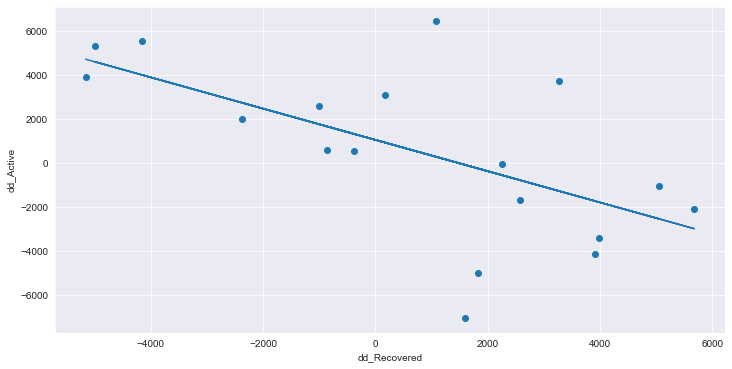

In [32]:
d_yr, d_ya = np.diff(yr), np.diff(ya)  # first difference
dd_yr, dd_ya = np.diff(d_yr), np.diff(d_ya)  # second difference
plt.scatter(dd_yr, dd_ya)

# Outlier detection
data = np.array([dd_yr, dd_ya]).T
outlier_detector = skc.EllipticEnvelope().fit(data)
in_data = outlier_detector.predict(data) == 1
data = data[in_data]  # outlier removed

dd_x, dd_y = data[:,[0]], data[:,[1]]
model2 = sklm.LinearRegression()
model2.fit(dd_x, dd_y)

plt.plot(dd_x, model2.predict(dd_x))
plt.xlabel('dd_Recovered')
plt.ylabel('dd_Active')
print('R2 score:', model2.score(dd_x, dd_y))
print('RMSE error:', np.sqrt(((model2.predict(dd_x)-dd_y)**2).mean()))

In [33]:
d_pyr = pyr - yr[-1]  # new first difference
dd_pyr = d_pyr - d_yr[-1]  # new second difference
dd_pya = np.round(model2.predict([[dd_pyr]])).astype(int)[0][0]  # predicted second difference
d_pya = dd_pya + d_ya[-1]  # predicted first difference
pya = d_pya + ya[-1]  # predicted active cases

In [34]:
print('Predicted active cases:', pya)
print('Predicted recovery:', pyr)
print('Predicted deaths:', pyd)
print('Predicted confirmations:', pya + pyr + pyd)

Predicted active cases: 544592
Predicted recovery: 1053614
Predicted deaths: 36058
Predicted confirmations: 1634264


## Checking some accuracy

In [35]:
window_size, n = 20, 0
summ = np.zeros(4)
rmse_sum = np.zeros(4)
for i in range(-100, -window_size-1):
    df_data = df.iloc[i:i+window_size]
    df_real = df.iloc[i+window_size]
    df_pred = predict(df_data, verbose=False)

#     print()
#     lines = [str(df_real).splitlines(), str(df_pred).splitlines()]
#     for l in zip(*lines):
#         a, b = l
#         print(a.ljust(50), b)
#     print()

    summ += np.abs(df_real - df_pred) / df_real
    rmse_sum += np.abs(df_real - df_pred)**2
    n += 1

print(f'Checking for {n} instances and with {window_size} cases per window...')
print('Average percentage error per column')
avg = summ / n
print(f'    Active: {avg[0]:.2%}')
print(f'    Recovered: {avg[1]:.2%}')
print(f'    Deaths: {avg[2]:.2%}')
print(f'    Confirmed: {avg[3]:.2%}')

print('\nRMSE')
rmse = np.sqrt(rmse_sum/n)
print(f'    Active: {rmse[0]}')
print(f'    Recovered: {rmse[1]}')
print(f'    Deaths: {rmse[2]}')
print(f'    Confirmed: {rmse[3]}')

Checking for 79 instances and with 20 cases per window...
Average percentage error per column
    Active: 2.79%
    Recovered: 2.83%
    Deaths: 3.13%
    Confirmed: 0.40%

RMSE
    Active: 6581.365343514226
    Recovered: 6940.214923896336
    Deaths: 542.7674047842248
    Confirmed: 2033.237584727709


In [36]:
window_size, n = 20, 0
summ = np.zeros(4)
rmse_sum = np.zeros(4)
pdr, pdp = pd.DataFrame(), pd.DataFrame()
for i in range(-100, -window_size-1):
    df_data = df.iloc[i:i+window_size]
    df_real = df.iloc[i+window_size]
    df_pred = predict(df_data, verbose=False)

    pdr = pdr.append(df_real)
    pdp = pdp.append(df_pred)

pdp.columns = map(lambda x: f'p_{x}', cols)
res = pd.concat([pdr,pdp], axis=1)
res.iplot(title='Real Vs Prediction', xTitle='Date', yTitle='Number of Cases')